In [8]:
import numpy as np
import matplotlib.pyplot as plt

import illustris_python as il
import pandas as pd
from matplotlib.gridspec import SubplotSpec
from scipy import stats

In [1]:
pwd

'/Users/festabu/Desktop/ML_galaxy_size_project/Codes'

In [2]:
basePath_TNG50 = '/Users/festabu/TNG50-1/output'
basePath_TNG100 = '/Users/festabu/TNG100-1/output'

In [3]:
fields2 = ['SubhaloHalfmassRadType','SubhaloMassInRadType', 'SubhaloSFRinRad', 'SubhaloFlag']

# 'SubhaloHalfmassRadType' = Comoving radius containing half of the mass of this Subhalo split by Type (SubhaloMassType).
# 'SubhaloMassInRadType' = Sum of masses of all particles/cells (split by type) within twice the stellar half mass radius.
# 'SubhaloSFRinRad' = Same as SubhaloSFR, but restricted to cells within twice the stellar half mass radius.
# 'SubhaloFlag' = Flag field indicating suitability of this subhalo for certain types of analysis. If zero, this subhalo should generally be excluded, and is not thought to be of cosmological origin. That is, it may have formed within an existing halo, or is possibly a baryonic fragment of a disk or other galactic structure identified by Subfind. If one, this subhalo should be considered a 'galaxy' or 'satellite' of cosmological origin. (Note: always true for centrals). See the data release background for details.
#                 subhalo flag to distinguish between centrals and satellites   

#### Note: DubhsloFlsg only distinguishes between galaxies of cosmoological origin and those
#### of non-cosmological origin. That's why we need another way to distinguish central and satellite galaxies
#### (in the galaxies of cosomological subset)

### Define functions

In [4]:
def load_galaxies (basePath, snapshot, fields):
    '''Loads subhalos and defines galaxy mass, galaxy size, SFR and subhalo_flag'''
    
    subhalos = il.groupcat.loadSubhalos(basePath,snapshot,fields=fields)
    
    # define galaxy size
    galaxy_size = subhalos['SubhaloHalfmassRadType'][:,4]
    galaxy_size = galaxy_size/0.7 # divide by h=0.7
    
    # define galaxy mass as only the stellar component
    galaxy_mass = subhalos['SubhaloMassInRadType'][:,4]
    galaxy_mass = (galaxy_mass/0.7)*1e10 # multiply galaxy mass by 1e10 and divide by h=0.7
    
    # define star formation rate
    SFR = subhalos['SubhaloSFRinRad']
    
    # subhalo_flag
    subhalo_flag = subhalos['SubhaloFlag']
    
    return subhalos, galaxy_mass, galaxy_size, SFR, subhalo_flag

In [5]:
def create_mysample(df, type_of_galaxy='central'):
    '''
    Converts to log10 non-zero size and mass entries for central and satellite galaxies
    output: df with new columns of log mass, log size added to it
    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['galaxy_mass'] > 0]

    #subhalo_flag = subhalos[‘SubhaloFlag’]
    if type_of_galaxy == 'central':
        df=df[df['subhalo_flag']==True]
    elif type_of_galaxy == 'satellite':
        df=df[df['subhalo_flag']==False]
    else: 
        print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
    df['galaxy_size_log']=np.log10(df['galaxy_size'])

    return df

In [6]:
def log_func(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['galaxy_mass'] > 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
    df['galaxy_size_log']=np.log10(df['galaxy_size'])

    return df

In [9]:
galaxies_TNG50=load_galaxies(basePath_TNG50, 99, fields2)

In [11]:
galaxies_TNG100=load_galaxies(basePath_TNG100, 99, fields2)

In [13]:
#galaxies_TNG100[0]

### <font color='blue'> Define df for TNG50 </font>

In [14]:
d_TNG50 = {'galaxy_mass': galaxies_TNG50[1], 'galaxy_size': galaxies_TNG50[2], 'SFR': galaxies_TNG50[3], 'subhalo_flag': galaxies_TNG50[4] }

In [15]:
df_TNG50 = pd.DataFrame(data=d_TNG50)

In [16]:
df_TNG50.head(2)

,galaxy_mass,galaxy_size,SFR,subhalo_flag
0,3.515673e+12,41.830242,0.155921,True
1,2.643969e+11,8.159544,0.000000,True


In [17]:
df_TNG50.shape

(5688113, 4)

#### <font color='red'> 1st way: using create_mysample function </font>

In [18]:
df_TNG50_centrals = create_mysample(df_TNG50)
#and now you can access the log size with df_centrals['galaxy_size_log']

In [19]:
# define satellites
df_TNG50_satellite = create_mysample(df_TNG50, type_of_galaxy='satellite')

In [20]:
# remove all satellites with logMstar>8
df_TNG50_satellite_filtered=df_TNG50_satellite.loc[(df_TNG50_satellite.galaxy_mass_log>=8) , :] 

In [21]:
df_TNG50_satellite_filtered.shape

(524, 6)

In [22]:
df_TNG50_centrals.shape

(98342, 6)

In [23]:
# remove all centrals with logMstar>8
df_TNG50_centrals_filtered=df_TNG50_centrals.loc[(df_TNG50_centrals.galaxy_mass_log>=8) , :]

In [24]:
df_TNG50_centrals_filtered.shape

(7282, 6)

#### <font color='red'> 2nd way: first take log of all mass & size columns, then choose only logMstar>8, then add the centrals/satellites column </font>

In [25]:
df_TNG50_log=log_func(df_TNG50)

<ipython-input-6-5bbe36d9b0bf>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
<ipython-input-6-5bbe36d9b0bf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['galaxy_size_log']=np.log10(df['galaxy_size'])


In [26]:
df_TNG50_log.head(2)

,galaxy_mass,galaxy_size,SFR,subhalo_flag,galaxy_mass_log,galaxy_size_log
0,3.515673e+12,41.830242,0.155921,True,12.546008,1.621490
1,2.643969e+11,8.159544,0.000000,True,11.422256,0.911666


In [27]:
df_TNG50_mass_filtered = df_TNG50_log.loc[(df_TNG50_log.galaxy_mass_log>=8) , :] # choose only galaxies that have a mass of logMstar>8

In [28]:
df_TNG50_mass_filtered.shape

(7806, 6)

In [29]:
# add a column that labels galaxy type
df_TNG50_mass_filtered['galaxy_type'] = df_TNG50_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag'] else 'satellite', axis=1)

<ipython-input-29-d6d56a088804>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG50_mass_filtered['galaxy_type'] = df_TNG50_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag'] else 'satellite', axis=1)


In [30]:
df_TNG50_mass_filtered['galaxy_type'].value_counts()

central      7282
satellite     524
Name: galaxy_type, dtype: int64

In [31]:
df_TNG50_mass_filtered.head(2)

,galaxy_mass,galaxy_size,SFR,subhalo_flag,galaxy_mass_log,galaxy_size_log,galaxy_type
0,3.515673e+12,41.830242,0.155921,True,12.546008,1.621490,central
1,2.643969e+11,8.159544,0.000000,True,11.422256,0.911666,central


### <font color='blue'> Define df for TNG100 

In [32]:
d_TNG100 = {'galaxy_mass': galaxies_TNG100[1], 'galaxy_size': galaxies_TNG100[2], 'SFR': galaxies_TNG100[3], 'subhalo_flag': galaxies_TNG100[4] }

In [33]:
df_TNG100 = pd.DataFrame(data=d_TNG100)

In [34]:
df_TNG100.head(2)

,galaxy_mass,galaxy_size,SFR,subhalo_flag
0,2.340489e+12,67.697227,0.195825,True
1,3.675859e+11,24.303402,0.088085,True


In [35]:
df_TNG100.shape

(4371211, 4)

In [36]:
df_TNG100_log=log_func(df_TNG100)

<ipython-input-6-5bbe36d9b0bf>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['galaxy_mass_log']=np.log10(df['galaxy_mass'])
<ipython-input-6-5bbe36d9b0bf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['galaxy_size_log']=np.log10(df['galaxy_size'])


In [37]:
df_TNG100_log.shape

(212929, 6)

In [38]:
df_TNG100_mass_filtered = df_TNG100_log.loc[(df_TNG100_log.galaxy_mass_log>=8) , :] # choose only galaxies that have a mass of logMstar>8

In [39]:
df_TNG100_mass_filtered.shape

(50668, 6)

In [40]:
# add a column that labels galaxy type
df_TNG100_mass_filtered['galaxy_type'] = df_TNG100_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag']==True else 'satellite', axis=1)

<ipython-input-40-cecfd957d32d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG100_mass_filtered['galaxy_type'] = df_TNG100_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag']==True else 'satellite', axis=1)


In [41]:
df_TNG100_mass_filtered['galaxy_type'].value_counts()

central      46215
satellite     4453
Name: galaxy_type, dtype: int64

In [42]:
df_TNG100_mass_filtered.head(2)

,galaxy_mass,galaxy_size,SFR,subhalo_flag,galaxy_mass_log,galaxy_size_log,galaxy_type
0,2.340489e+12,67.697227,0.195825,True,12.369307,1.830571,central
1,3.675859e+11,24.303402,0.088085,True,11.565359,1.385667,central


### <font color='blue'> Mass and Size Definitions 

In [46]:
central_TNG50 = df_TNG50_mass_filtered.loc[df_TNG50_mass_filtered["galaxy_type"] == 'central', ["galaxy_mass_log","galaxy_size_log", 'SFR']]
central_galaxies_mass_TNG50=central_TNG50["galaxy_mass_log"]
central_galaxies_size_TNG50=central_TNG50["galaxy_size_log"]
central_galaxies_SFR_TNG50=central_TNG50["SFR"]

satellite_TNG50 = df_TNG50_mass_filtered.loc[df_TNG50_mass_filtered["galaxy_type"] == 'satellite', ["galaxy_mass_log","galaxy_size_log", 'SFR']]
satellite_galaxies_mass_TNG50=satellite_TNG50["galaxy_mass_log"]
satellite_galaxies_size_TNG50=satellite_TNG50["galaxy_size_log"]
satellite_galaxies_SFR_TNG50=satellite_TNG50["SFR"]

central_TNG100 = df_TNG100_mass_filtered.loc[df_TNG100_mass_filtered["galaxy_type"] == 'central', ["galaxy_mass_log","galaxy_size_log", 'SFR']]
central_galaxies_mass_TNG100=central_TNG100["galaxy_mass_log"]
central_galaxies_size_TNG100=central_TNG100["galaxy_size_log"]
central_galaxies_SFR_TNG100=central_TNG100["SFR"]

satellite_TNG100 = df_TNG100_mass_filtered.loc[df_TNG100_mass_filtered["galaxy_type"] == 'satellite', ["galaxy_mass_log","galaxy_size_log", 'SFR']]
satellite_galaxies_mass_TNG100=satellite_TNG100["galaxy_mass_log"]
satellite_galaxies_size_TNG100=satellite_TNG100["galaxy_size_log"]
satellite_galaxies_SFR_TNG100=satellite_TNG100["SFR"]

### Plots

In [43]:
def plot_df_mass_size_sfr(df, galaxy_type = 'central'):
    
    sub_df = df.loc[df["galaxy_type"] == galaxy_type, ["galaxy_mass_log","galaxy_size_log", 'SFR']]
    plt.scatter(sub_df["galaxy_mass_log"], sub_df["galaxy_size_log"], c = np.log10(sub_df['SFR']+0.01), 
                s=30, marker='o', label='Star Formation Rate [$M_\odot / yr$] \n mass-size correlation=0.66')
    plt.xlabel('Total Mass [$M_\odot$]')
    plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
    plt.legend(shadow = True)
    plt.colorbar()
    plt.show()

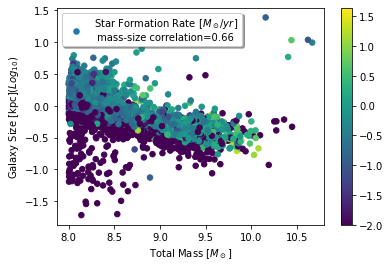

In [44]:
plot_df_mass_size_sfr(df_TNG100_mass_filtered, galaxy_type= 'satellite')

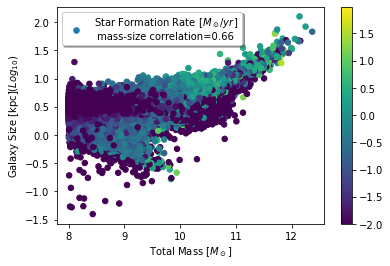

In [45]:
plot_df_mass_size_sfr(df_TNG100_mass_filtered, galaxy_type= 'central')

## Size vs Mass, and SFR

#### <font color='blue'> Spearman correlations 

In [47]:
mass_size_corr_central_TNG50 = stats.spearmanr(central_galaxies_mass_TNG50, central_galaxies_size_TNG50 )
SFR_size_corr_central_TNG50 = stats.spearmanr(central_galaxies_SFR_TNG50, central_galaxies_size_TNG50 )
SFR_mass_corr_central_TNG50 = stats.spearmanr(central_galaxies_SFR_TNG50, central_galaxies_mass_TNG50 )

mass_size_corr_satellite_TNG50 = stats.spearmanr(satellite_galaxies_mass_TNG50, satellite_galaxies_size_TNG50 )
SFR_size_corr_satellite_TNG50 = stats.spearmanr(satellite_galaxies_SFR_TNG50, satellite_galaxies_size_TNG50 )
SFR_mass_corr_satellite_TNG50 = stats.spearmanr(satellite_galaxies_SFR_TNG50, satellite_galaxies_mass_TNG50 )

mass_size_corr_central_TNG100 = stats.spearmanr(central_galaxies_mass_TNG100, central_galaxies_size_TNG100 )
SFR_size_corr_central_TNG100 = stats.spearmanr(central_galaxies_SFR_TNG100, central_galaxies_size_TNG100 )
SFR_mass_corr_central_TNG100 = stats.spearmanr(central_galaxies_SFR_TNG100, central_galaxies_mass_TNG100 )

mass_size_corr_satellite_TNG100 = stats.spearmanr(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100 )
SFR_size_corr_satellite_TNG100 = stats.spearmanr(satellite_galaxies_SFR_TNG100, satellite_galaxies_size_TNG100 )
SFR_mass_corr_satellite_TNG100 = stats.spearmanr(satellite_galaxies_SFR_TNG100, satellite_galaxies_mass_TNG100 )

print('mass_size_corr_central_TNG100', mass_size_corr_central_TNG100)
print('SFR_size_corr_central_TNG100', SFR_size_corr_central_TNG100)
print('SFR_mass_corr_central_TNG100', SFR_mass_corr_central_TNG100)

mass_size_corr_central_TNG100 SpearmanrResult(correlation=0.23586652999080335, pvalue=0.0)
SFR_size_corr_central_TNG100 SpearmanrResult(correlation=0.015105196019656538, pvalue=0.0011647962030185315)
SFR_mass_corr_central_TNG100 SpearmanrResult(correlation=0.44845223686987645, pvalue=0.0)


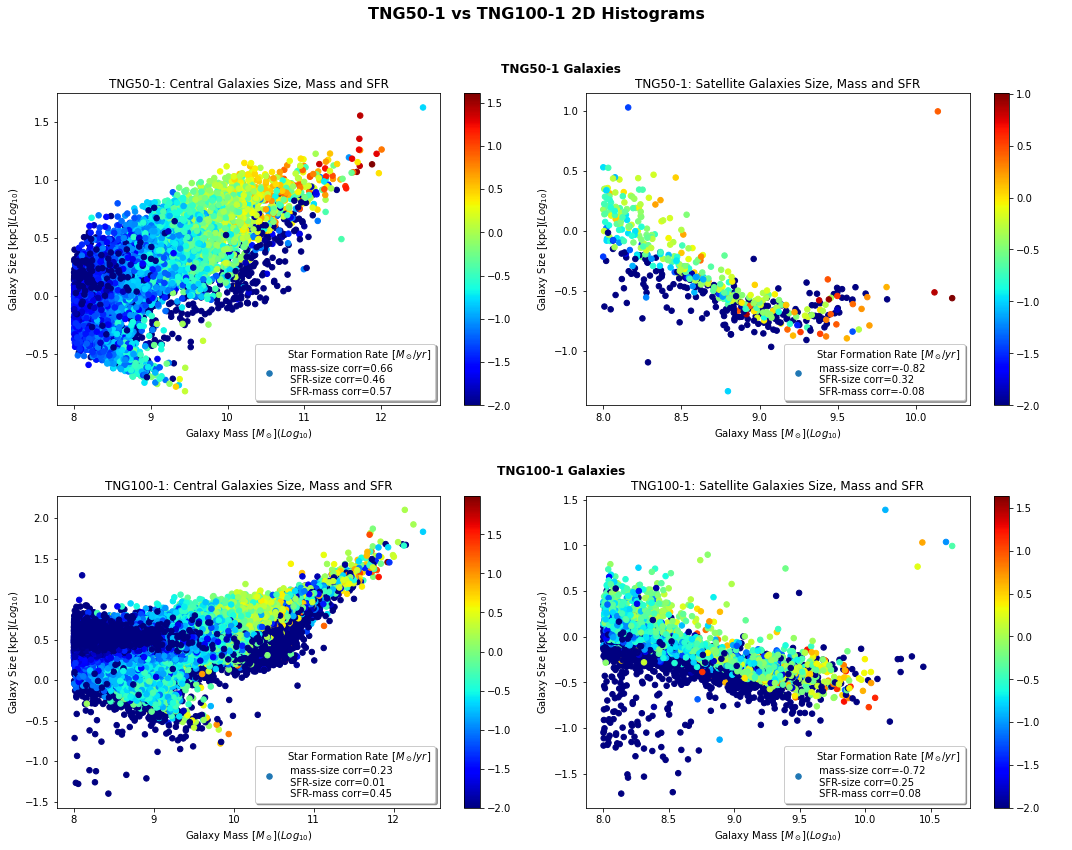

In [48]:
import matplotlib.cm as cm
import matplotlib.colors as norm

fig4,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig4.suptitle('TNG50-1 vs TNG100-1 2D Histograms', fontsize=16, fontweight='bold')

im1 = ax1.scatter(central_galaxies_mass_TNG50, central_galaxies_size_TNG50, 
                  c = np.log10(central_galaxies_SFR_TNG50 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.66 \n SFR-size corr=0.46 \n SFR-mass corr=0.57')
ax1.set_title('TNG50-1: Central Galaxies Size, Mass and SFR')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax1.legend(loc='lower right', shadow=True)
fig4.colorbar(im1, ax=ax1)

im2 = ax2.scatter(satellite_galaxies_mass_TNG50, satellite_galaxies_size_TNG50, 
                  c = np.log10(satellite_galaxies_SFR_TNG50 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=-0.82 \n SFR-size corr=0.32 \n SFR-mass corr=-0.08')
ax2.set_title('TNG50-1: Satellite Galaxies Size, Mass and SFR')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)
fig4.colorbar(im2, ax=ax2)

im3 = ax3.scatter(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, 
                  c = np.log10(central_galaxies_SFR_TNG100 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.23 \n SFR-size corr=0.01 \n SFR-mass corr=0.45')
ax3.set_title('TNG100-1: Central Galaxies Size, Mass and SFR')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax3.legend( loc='lower right', shadow=True)
fig4.colorbar(im3, ax=ax3)

im4 = ax4.scatter(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, 
                  c = np.log10(satellite_galaxies_SFR_TNG100 + 0.01), cmap = plt.cm.jet, s=30, marker='o', 
                  label='Star Formation Rate [$M_\odot / yr$] \n mass-size corr=-0.72 \n SFR-size corr=0.25 \n SFR-mass corr=0.08')
ax4.set_title('TNG100-1: Satellite Galaxies Size, Mass and SFR')
ax4.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax4.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.legend(loc='lower right', shadow=True)
fig4.colorbar(im4, ax=ax4)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid4 = plt.GridSpec(2, 2)
create_subtitle(fig4, grid4[0, ::], 'TNG50-1 Galaxies')
create_subtitle(fig4, grid4[1, ::], 'TNG100-1 Galaxies')
fig4.tight_layout()
fig4.subplots_adjust(top=0.88)

#plt.savefig("TNG501_vs_TNG1001_central_satellite_SFR.jpeg", dpi=500)
plt.show()

### Scatter plot

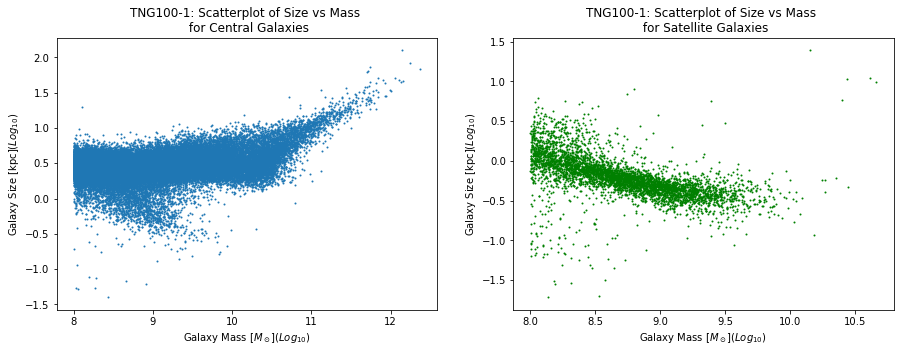

In [50]:
fig3,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax1.plot(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, '.', markersize=2)
ax1.set_title('TNG100-1: Scatterplot of Size vs Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')

ax2.plot(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, '.', markersize=2, color='g')
ax2.set_title('TNG100-1: Scatterplot of Size vs Mass \n for Satellite Galaxies')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.show()

#plt.savefig("TNG501_central_satellite_scatterplot.jpeg", dpi=500)

### Plot the 1D histograms

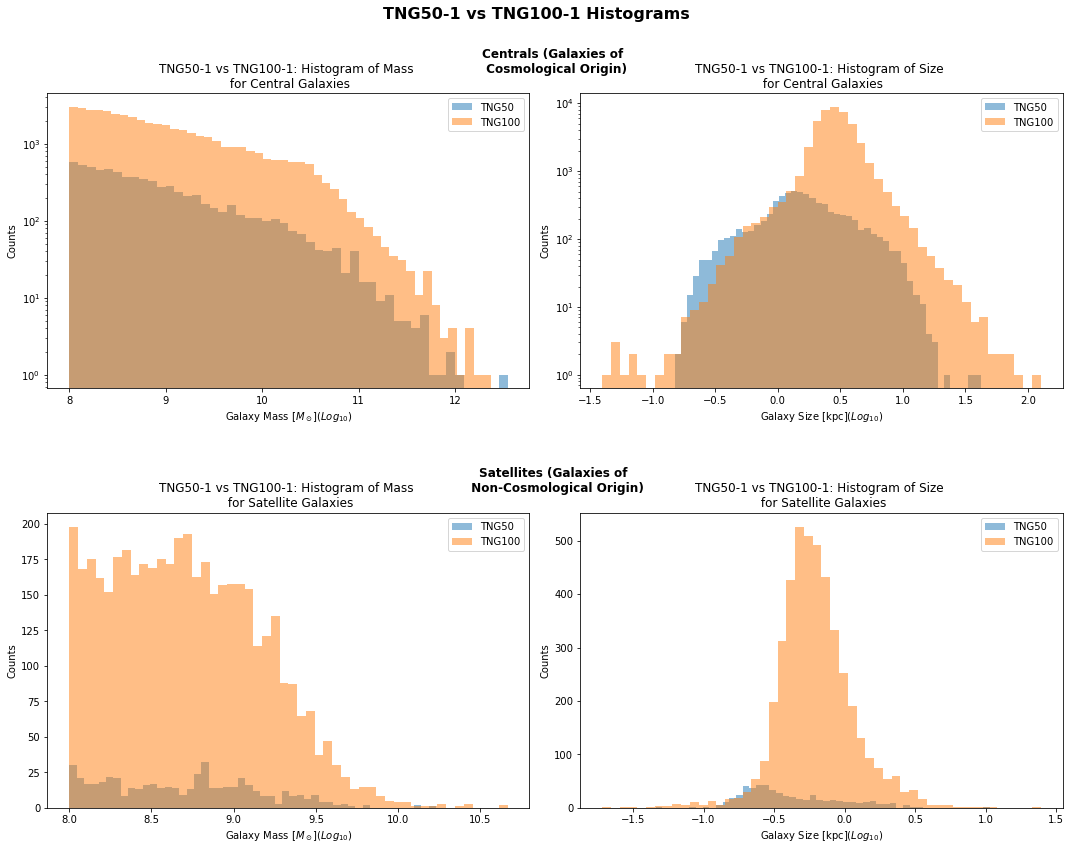

In [61]:
fig,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig.suptitle('TNG50-1 vs TNG100-1 Histograms', fontsize=16, fontweight='bold')

ax1.hist(central_galaxies_mass_TNG50, bins=50, log=True, alpha=0.5, label='TNG50')
ax1.hist(central_galaxies_mass_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax1.set_title('TNG50-1 vs TNG100-1: Histogram of Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(central_galaxies_size_TNG50,bins=50, log=True, alpha=0.5, label='TNG50')
ax2.hist(central_galaxies_size_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax2.set_title('TNG50-1 vs TNG100-1: Histogram of Size \n for Central Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(satellite_galaxies_mass_TNG50, bins=50, alpha=0.5, label='TNG50')
ax3.hist(satellite_galaxies_mass_TNG100, bins=50, alpha=0.5, label='TNG100')
ax3.set_title('TNG50-1 vs TNG100-1: Histogram of Mass \n for Satellite Galaxies')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(satellite_galaxies_size_TNG50, bins=50, alpha=0.5, label='TNG50')
ax4.hist(satellite_galaxies_size_TNG100, bins=50, alpha=0.5, label='TNG100')
ax4.set_title('TNG50-1 vs TNG100-1: Histogram of Size \n for Satellite Galaxies')
ax4.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.set_ylabel('Counts')
ax4.legend(loc='upper right')

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Centrals (Galaxies of \n Cosmological Origin)')
create_subtitle(fig, grid[1, ::], 'Satellites (Galaxies of \n Non-Cosmological Origin)')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
#plt.savefig("TNG501_vs_TNG1001_Hist1D.jpeg", dpi=500)
plt.show()

### Mass and Size Density (divide the count number by the volume of the simulation, weights property of hist)

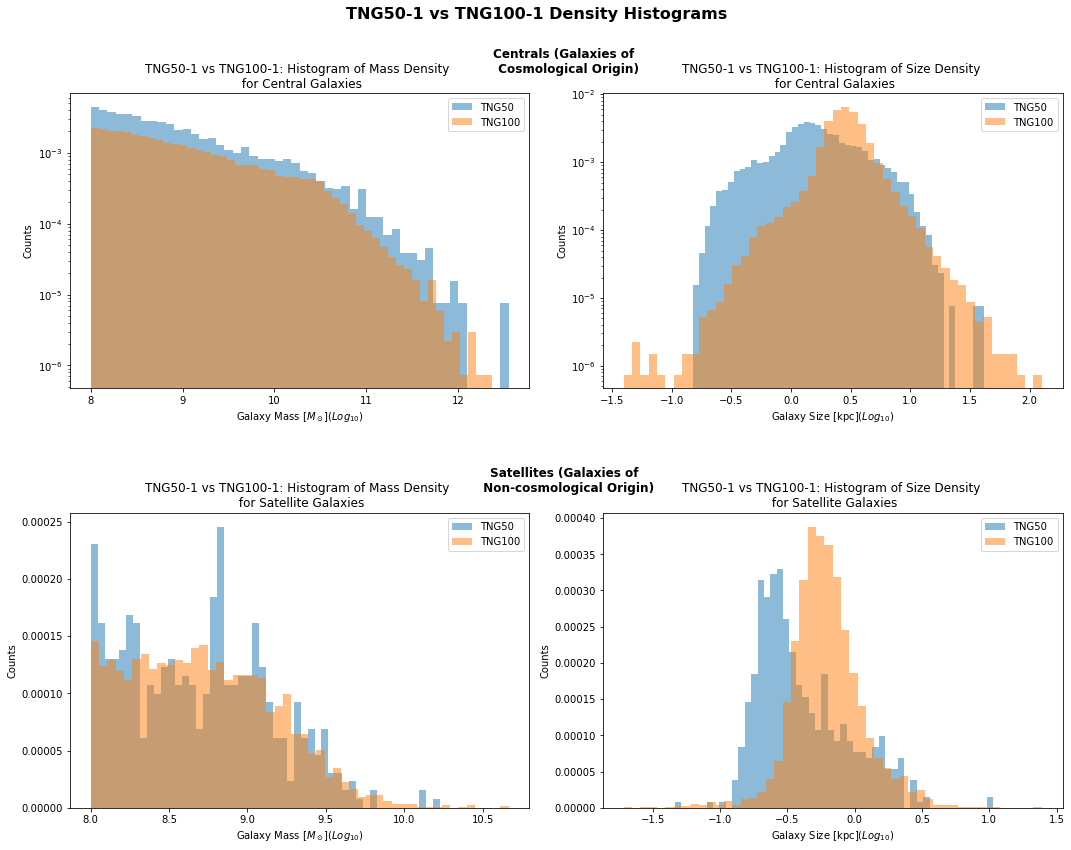

In [62]:
fig,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig.suptitle('TNG50-1 vs TNG100-1 Density Histograms', fontsize=16, fontweight='bold')

ax1.hist(central_galaxies_mass_TNG50, bins=50, weights = [1/(50.7**3)]*central_galaxies_mass_TNG50.shape[0],
                 log=True, alpha=0.5, label='TNG50')
ax1.hist(central_galaxies_mass_TNG100, bins=50, weights = [1/(110.7**3)]*central_galaxies_mass_TNG100.shape[0],
         log=True, alpha=0.5, label='TNG100')
ax1.set_title('TNG50-1 vs TNG100-1: Histogram of Mass Density \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(central_galaxies_size_TNG50,bins=50, weights = [1/(50.7**3)]*central_galaxies_size_TNG50.shape[0],
         log=True, alpha=0.5, label='TNG50')
ax2.hist(central_galaxies_size_TNG100, bins=50, weights = [1/(110.7**3)]*central_galaxies_size_TNG100.shape[0],
         log=True, alpha=0.5, label='TNG100')
ax2.set_title('TNG50-1 vs TNG100-1: Histogram of Size Density \n for Central Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(satellite_galaxies_mass_TNG50, bins=50, weights = [1/(50.7**3)]*satellite_galaxies_mass_TNG50.shape[0],
         alpha=0.5, label='TNG50')
ax3.hist(satellite_galaxies_mass_TNG100, bins=50, weights = [1/(110.7**3)]*satellite_galaxies_mass_TNG100.shape[0], 
         alpha=0.5, label='TNG100')
ax3.set_title('TNG50-1 vs TNG100-1: Histogram of Mass Density \n for Satellite Galaxies')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(satellite_galaxies_size_TNG50, bins=50, weights = [1/(50.7**3)]*satellite_galaxies_size_TNG50.shape[0],
         alpha=0.5, label='TNG50')
ax4.hist(satellite_galaxies_size_TNG100, bins=50,weights = [1/(110.7**3)]*satellite_galaxies_size_TNG100.shape[0], 
         alpha=0.5, label='TNG100')
ax4.set_title('TNG50-1 vs TNG100-1: Histogram of Size Density \n for Satellite Galaxies')
ax4.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.set_ylabel('Counts')
ax4.legend(loc='upper right')

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Centrals (Galaxies of \n Cosmological Origin)')
create_subtitle(fig, grid[1, ::], 'Satellites (Galaxies of \n Non-cosmological Origin)')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
#plt.savefig("TNG501_vs_TNG1001_DensityHist1D.jpeg", dpi=500)
plt.show()

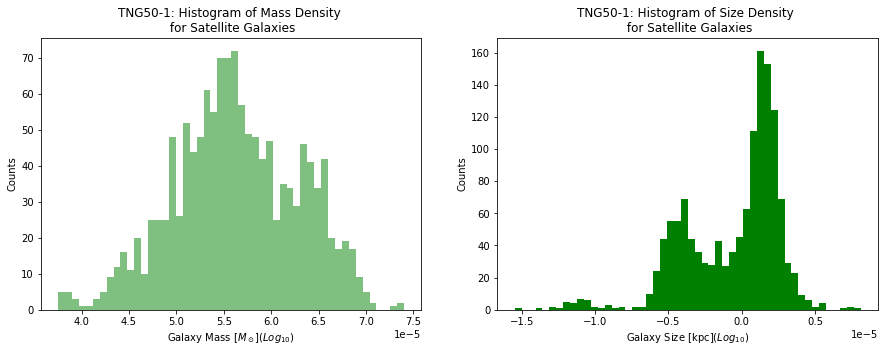

In [48]:
fig4,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax1.hist(satellite_galaxies_mass/((51.7)**3), facecolor='g', bins=50, alpha=0.5)
ax1.set_title('TNG50-1: Histogram of Mass Density \n for Satellite Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')

ax2.hist(satellite_galaxies_size/((51.7)**3), facecolor='g', bins=50)
ax2.set_title('TNG50-1: Histogram of Size Density \n for Satellite Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')

#plt.savefig("TNG501_satellite_Hist1D.jpeg", dpi=500)
plt.show()



### Plot the 2D histograms

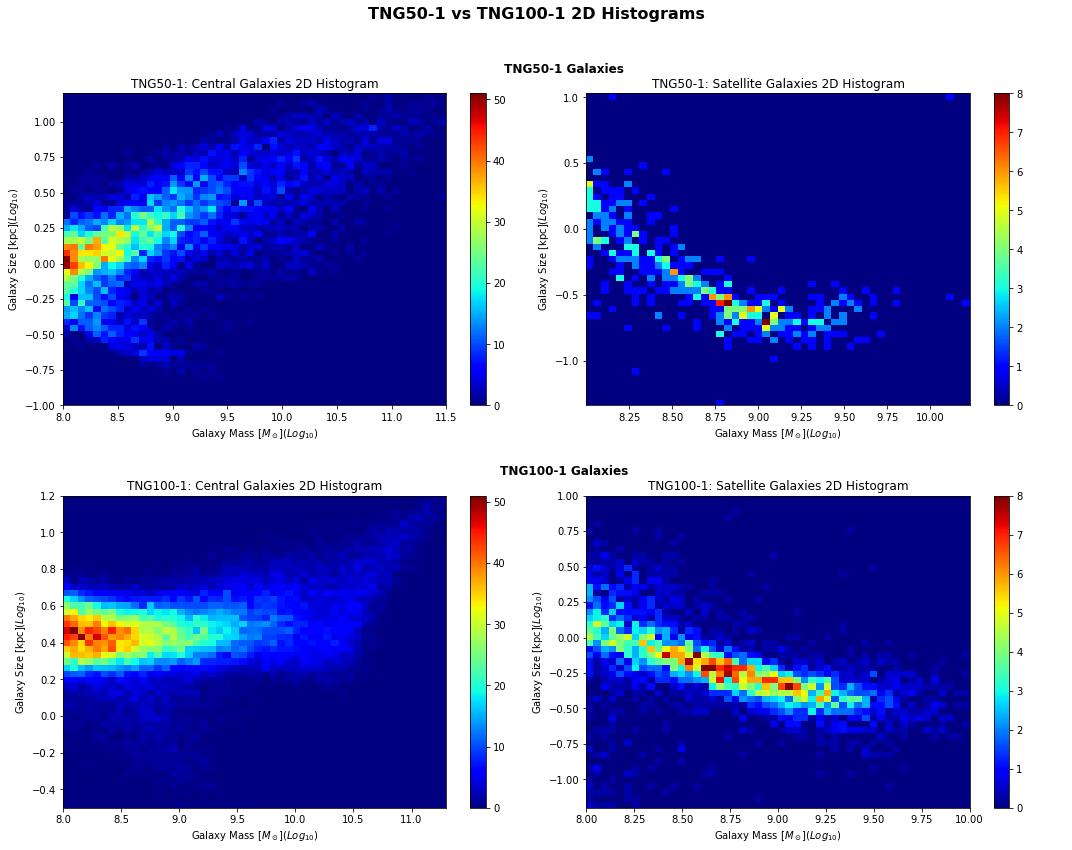

In [97]:
# Figure using the Matplotlib hist2d
import matplotlib.cm as cm
import matplotlib.colors as norm

fig3,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))
fig3.suptitle('TNG50-1 vs TNG100-1 2D Histograms', fontsize=16, fontweight='bold')

im1 = ax1.hist2d(central_galaxies_mass_TNG50, central_galaxies_size_TNG50, cmap = plt.cm.jet, bins=50, range=[[8,11.5],[-1.0,1.2]])
ax1.set_title('TNG50-1: Central Galaxies 2D Histogram')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im1[3], ax=ax1)

im2 = ax2.hist2d(satellite_galaxies_mass_TNG50, satellite_galaxies_size_TNG50, cmap = plt.cm.jet, bins=50)
ax2.set_title('TNG50-1: Satellite Galaxies 2D Histogram')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im2[3], ax=ax2)

im3 = ax3.hist2d(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, cmap = plt.cm.jet, bins=50, range=[[8,11.3],[-0.5,1.2]])
ax3.set_title('TNG100-1: Central Galaxies 2D Histogram')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im1[3], ax=ax3)

im4 = ax4.hist2d(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, cmap = plt.cm.jet, bins=50, range=[[8,10.0],[-1.2,1.0]])
ax4.set_title('TNG100-1: Satellite Galaxies 2D Histogram')
ax4.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax4.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig3.colorbar(im2[3], ax=ax4)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid3 = plt.GridSpec(2, 2)
create_subtitle(fig3, grid3[0, ::], 'TNG50-1 Galaxies')
create_subtitle(fig3, grid3[1, ::], 'TNG100-1 Galaxies')
fig3.tight_layout()
fig3.subplots_adjust(top=0.88)

#plt.savefig("TNG501_vs_TNG1001_central_satellite_Hist2D.jpeg", dpi=500)
plt.show()


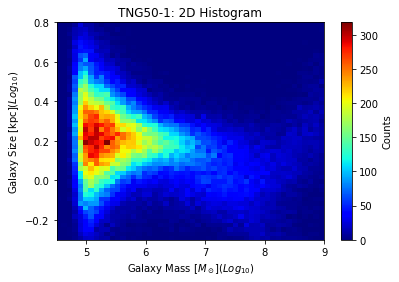

In [33]:
# Figure using the Matplotlib hist2d where histogram range is defined

plt.hist2d(central_galaxies_mass, central_galaxies_size, cmap = plt.cm.jet, bins=50,  range=[[4.5,9],[-0.3,0.8]]  )
plt.title('TNG50-1: 2D Histogram')
plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_Hist2D_v2.jpeg", dpi=500)
plt.show()

### Histogram 2D and Scatter Plot overlap

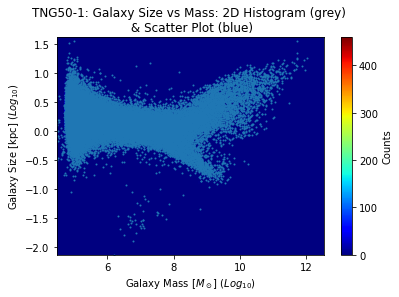

In [50]:
fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
#hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True)
plt.hist2d(galaxy_mass_log, galaxy_size_log, cmap = plt.cm.jet, bins=100)
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
plt.title('TNG50-1: Galaxy Size vs Mass: 2D Histogram (grey) \n & Scatter Plot (blue)')
plt.plot(galaxy_mass_log,galaxy_size_log, '.', markersize=2)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Galaxy Size [kpc] ($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $] ($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2d_and_scatterplot.jpeg", dpi=500)
plt.show()

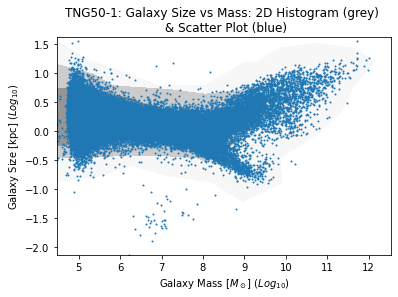

In [51]:
fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True)
plt.title('TNG50-1: Galaxy Size vs Mass: 2D Histogram (grey) \n & Scatter Plot (blue)')
plt.plot(galaxy_mass_log,galaxy_size_log, '.', markersize=2)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Galaxy Size [kpc] ($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $] ($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2d_and_scatterplot.jpeg", dpi=500)
plt.show()

### 2D Histogram function with contours

In [ ]:
def hist2dplot(axis,x,y,fill=True,**kwargs):
    
    h,xed,yed=np.histogram2d(x,y)
    
    
    h=np.transpose(h)
    total=h.sum()
    h=h/total
    hflat=np.sort(np.reshape(h,-1)) #makes 1D and sorted 
    csum=np.cumsum(hflat)
    values=1.0-np.array([0.9973,0.9545,0.6827,0.0])
    
    levels=[]
    
    for val in values:
        idx = (np.abs(csum - val)).argmin()
        levels.append(hflat[idx])

    if fill:
        #colors=['#f7f7f7','#cccccc','#969696','#525252'] #gray
        colors=['#ffffcc','#c2e699','#78c679','#238443'] #green 
        axis.contourf(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    else:
        colors=['#fdcc8a','#fc8d59','#d7301f']
        axis.contour(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    
    

In [ ]:
# Figure using the 2D Histogram function

fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, central_galaxies_mass_TNG100, central_galaxies_size_TNG100, fill=True, bins=1000)
hist2dplot(ax, central_galaxies_mass_TNG50, central_galaxies_size_TNG50, fill=False, bins=1000)
plt.title('TNG100-1: 2D Histogram with hist2d code function')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2Dplot_v1.jpeg", dpi=500)

In [ ]:
# Figure using the 2D Histogram function where histogram range is defined

fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True, bins=10, range=[[8,11],[0.4,1.4]])
plt.title('TNG50-1: 2D Histogram with hist2d code function')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2Dplot_v2.jpeg", dpi=500)